# Feature weights and penalties tutorial

In some applications it would be helpful to give model a hint to reduce the use of specific features. Some features may be less interpretable, which can be an important consideration when the model needs to be explained to non-technical audiences.

Another application is in time series, where a continuous time feature is useful to model changes over time, but vulnerable to overfitting because everything in a time series could be explained with enough splits on time.

Sometimes such hints may be harmful because the whole concept of machine learning is to use statistical analysis to assign optimal feature weights. Anyway catboost gives such a possibility through feature weights and penalties.

Feature weights are designed to change some features usage by specifying weight to each of them.

What do we need feature penalties for? Some object features can be more computationally expensive than another. For example, we want to make a diagnosis. It's much cheaper to take blood sample than X-ray, and in most cases blood sample is enough to diagnose. So it's would save us some resources to not X-ray if diagnosis is clear after taking blood sample.

[Cost efficient gradient boosting](https://papers.nips.cc/paper/6753-cost-efficient-gradient-boosting.pdf) is supposed to build models with less expensive-to-calculate features usage and less applying time. Feature computation time is specified through *per-object-feature-penalties* and *first-feature-use-penalties* (if feature is computed once for all objects) parameters. You can scale all feature penalties at once through *penalties-coefficient* param.

Algorithm uses given parameters by modifying split candidate score in the following way:

$$Score' = Score * \prod_{f\in S}W_f - \sum_{f\in S}P_f*U(f) - \sum_{f\in S}\sum_{x \in L}EP_f*U(f, x)$$

where

$W_f - feature\: weight$

$P_f - feature\: penalty$

$EP_f - elementwise\: feature\: penalty$

$S - current\:split$

$L - current\: leaf$

$U(f) = 
\begin{cases}
    0,& \text{if } f \text{ was used in model already}\\
    1,& \text{otherwise}
\end{cases}$

$U(f, x) = 
\begin{cases}
    0,& \text{if } f \text{ was used already for object } x\\
    1,& \text{otherwise}
\end{cases}$

Let's create a synthetic dataset to demonstrate feature penalties influence.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import catboost

In [2]:
seed = 33
np.random.seed(seed)

CEGB claims to produce trees with deep branches but low expected depth and feature cost, so let's try to build it.

Let's create a synthetic dataset for regression. Each next feature is supposed to be more costly than previous. Part of the data label depends on the first feature, part of the rest data label depends on the second feature and so on. So a perfect model would use only *n_features - 1* splits with each feature except the last one. 

In [3]:
def generate_dataset(n_objects, n_features):
    assert(n_objects % n_features == 0)
    
    X = np.random.rand(n_objects, n_features)
    y = np.zeros(n_objects, dtype=int)
    
    piece_len = n_objects // n_features
    for lvl in range(n_features):
        X[:, lvl] = X[:, lvl] / 2
        X[piece_len*lvl:piece_len*(lvl+1), lvl] = X[piece_len*lvl:piece_len*(lvl+1), lvl] + 0.5
        y[piece_len*lvl:piece_len*(lvl+1)] = lvl
    
    X, y = sklearn.utils.shuffle(X, y, random_state=seed)
    return catboost.Pool(X, y, cat_features=[], feature_names=list(map(str, range(n_features))))

In [4]:
n_objects=2**13
n_features=4

In [5]:
small_pool = generate_dataset(n_objects, n_features)

In [6]:
iterations_count=10

In [7]:
common_params = {
    'random_seed': seed,
    'grow_policy': 'Lossguide',
    'objective': 'RMSE',
    'iterations': iterations_count,
    'depth': n_features-1,
}

In [8]:
cb_wo_penalties = catboost.CatBoostRegressor(
    **common_params,
)

In [9]:
cb_wo_penalties.fit(small_pool)

Learning rate set to 0.5
0:	learn: 0.5723978	total: 66ms	remaining: 594ms
1:	learn: 0.2942938	total: 89.7ms	remaining: 359ms
2:	learn: 0.1588871	total: 113ms	remaining: 265ms
3:	learn: 0.0942765	total: 136ms	remaining: 204ms
4:	learn: 0.0639308	total: 158ms	remaining: 158ms
5:	learn: 0.0498856	total: 180ms	remaining: 120ms
6:	learn: 0.0456871	total: 202ms	remaining: 86.4ms
7:	learn: 0.0434958	total: 224ms	remaining: 56.1ms
8:	learn: 0.0427214	total: 244ms	remaining: 27.1ms
9:	learn: 0.0261691	total: 265ms	remaining: 0us


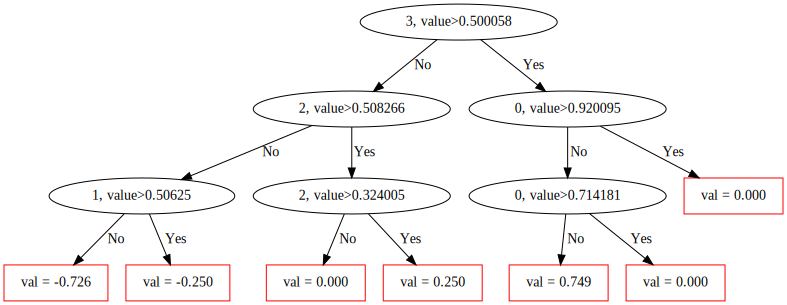

In [10]:
cb_wo_penalties.plot_tree(tree_idx=0, pool=small_pool)

We can see that the model without feature penalties uses some extra splits except three required ones, including splits with "costly" features.

In [11]:
def get_penalties(n_features, base=1.3):
    return list([base**lvl for lvl in range(n_features)])

In [12]:
cb_with_penalties = catboost.CatBoostRegressor(
    **common_params,
    penalties_coefficient=0.001,
    per_object_feature_penalties=get_penalties(n_features)
)

In [13]:
cb_with_penalties.fit(small_pool)

Learning rate set to 0.5
0:	learn: 0.5818967	total: 26.4ms	remaining: 237ms
1:	learn: 0.3140865	total: 44.3ms	remaining: 177ms
2:	learn: 0.1791524	total: 64.4ms	remaining: 150ms
3:	learn: 0.1166760	total: 86.3ms	remaining: 129ms
4:	learn: 0.0765730	total: 108ms	remaining: 108ms
5:	learn: 0.0616796	total: 127ms	remaining: 84.8ms
6:	learn: 0.0547723	total: 147ms	remaining: 63ms
7:	learn: 0.0481709	total: 169ms	remaining: 42.2ms
8:	learn: 0.0460998	total: 190ms	remaining: 21.1ms
9:	learn: 0.0428211	total: 214ms	remaining: 0us


We can see that loss of model with penalties is just twice the original loss.

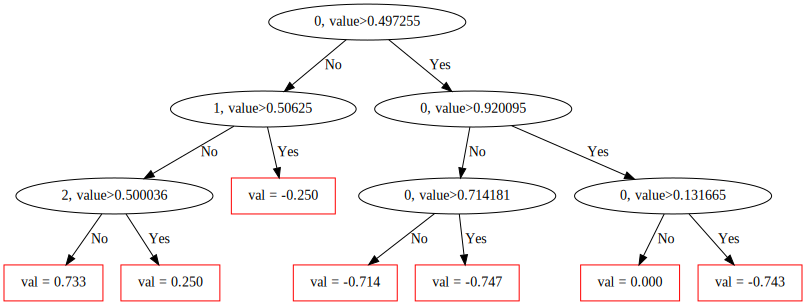

In [14]:
cb_with_penalties.plot_tree(tree_idx=0, pool=small_pool)

We can see that model with penalties doesn't have unnecessary splits with "costly" features 1 and 2.

**Note**: Too low feature penalties may have no effect on model while too big feature penalties may significantly decrease model quality. Be careful to use it!

Let's try to achieve similar results using only feature weights.

In [15]:
def get_weights(n_features, base=1.1):
    return list([(1/base)**lvl for lvl in range(n_features)])

In [16]:
cb_with_weights = catboost.CatBoostRegressor(
    **common_params,
    feature_weights=get_weights(n_features)
)

In [17]:
cb_with_weights.fit(small_pool)

Learning rate set to 0.5
0:	learn: 0.6531579	total: 18.3ms	remaining: 165ms
1:	learn: 0.3379231	total: 36.1ms	remaining: 144ms
2:	learn: 0.1898801	total: 53.7ms	remaining: 125ms
3:	learn: 0.1257772	total: 73.9ms	remaining: 111ms
4:	learn: 0.0868733	total: 95.1ms	remaining: 95.1ms
5:	learn: 0.0705268	total: 118ms	remaining: 78.4ms
6:	learn: 0.0644072	total: 140ms	remaining: 60ms
7:	learn: 0.0601975	total: 163ms	remaining: 40.8ms
8:	learn: 0.0548494	total: 184ms	remaining: 20.4ms
9:	learn: 0.0371757	total: 208ms	remaining: 0us


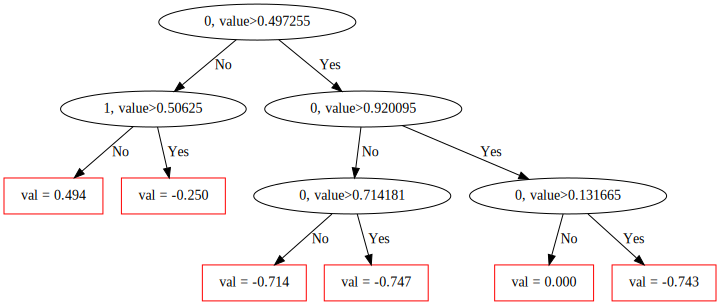

In [18]:
cb_with_weights.plot_tree(tree_idx=0, pool=small_pool)

We can see that tree also reduces "costly" features usage. Metric result is also comparable with model without feature weights.

We can also see that feature weights and penalties usage reduce overall feature strength of "costly" features.

In [19]:
def get_fs_col_name(feature_idx):
    return 'Feature strength {}'.format(feature_idx)

fs_df = pd.DataFrame(
    data=[
        cb_wo_penalties.get_feature_importance(
            type=catboost.EFstrType.PredictionValuesChange,
            data=small_pool
        ),
        cb_with_penalties.get_feature_importance(
            type=catboost.EFstrType.PredictionValuesChange,
            data=small_pool
        ),
        cb_with_weights.get_feature_importance(
            type=catboost.EFstrType.PredictionValuesChange,
            data=small_pool
        ),
    ],
    columns=list(map(get_fs_col_name, range(n_features))),
    index=['Simple regressor', 'Regressor with feature penalties', 'Regressor with feature weights']
)
for idx in range(1, n_features):
    fs_df['Relative feature strength {}'.format(idx)] = fs_df[get_fs_col_name(idx)] / fs_df[get_fs_col_name(0)]

In [20]:
fs_df

,Feature strength 0,Feature strength 1,Feature strength 2,Feature strength 3,Relative feature strenght 1,Relative feature strenght 2,Relative feature strenght 3
Simple regressor,13.090980,13.028802,25.600115,48.280102,0.995250,1.955554,3.688043
Regressor with feature penalties,60.241950,30.182175,9.568341,0.007533,0.501016,0.158832,0.000125
Regressor with feature weights,57.798581,23.163002,0.013350,19.025068,0.400754,0.000231,0.329162
